# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import random
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import spacy


/Users/admin/miniconda3/envs/film-junkie-union/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

/var/folders/t4/cv9v6mnn7svb1df20csb3s2r0000gn/T/ipykernel_9265/1225062909.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/Users/admin/Desktop/GitHub/new_repos/film-junkie-union/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
display(df_reviews.sample(5))
df_reviews.info()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
17032,tt0030252,movie,Hotel du Nord,Hôtel du Nord,1938,\N,95,0,"Drama,Romance",7.7,2139,"""Hotel du Nord "" is the only Carné movie from ...",9,pos,1,train,12295
11706,tt0101811,movie,Enchanted April,Enchanted April,1991,\N,95,0,Drama,7.3,5926,I first saw this movie back in the early '90's...,10,pos,1,train,443
40142,tt0067487,movie,The Night Evelyn Came Out of the Grave,La notte che Evelyn uscì dalla tomba,1971,\N,103,0,"Horror,Mystery,Thriller",5.7,2038,"Oh, those Italians! Assuming that movies about...",1,neg,0,train,11556
31877,tt0100665,movie,Soultaker,Soultaker,1990,\N,94,0,"Fantasy,Horror",2.4,3495,But at least this movie got what it deserved -...,1,neg,0,test,10802
17232,tt0097529,video,Houseboat Horror,Houseboat Horror,1989,\N,85,0,Horror,4.1,244,Houseboat Horror is a great title for this fil...,2,neg,0,train,9406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Let's check the number of movies and reviews over years.

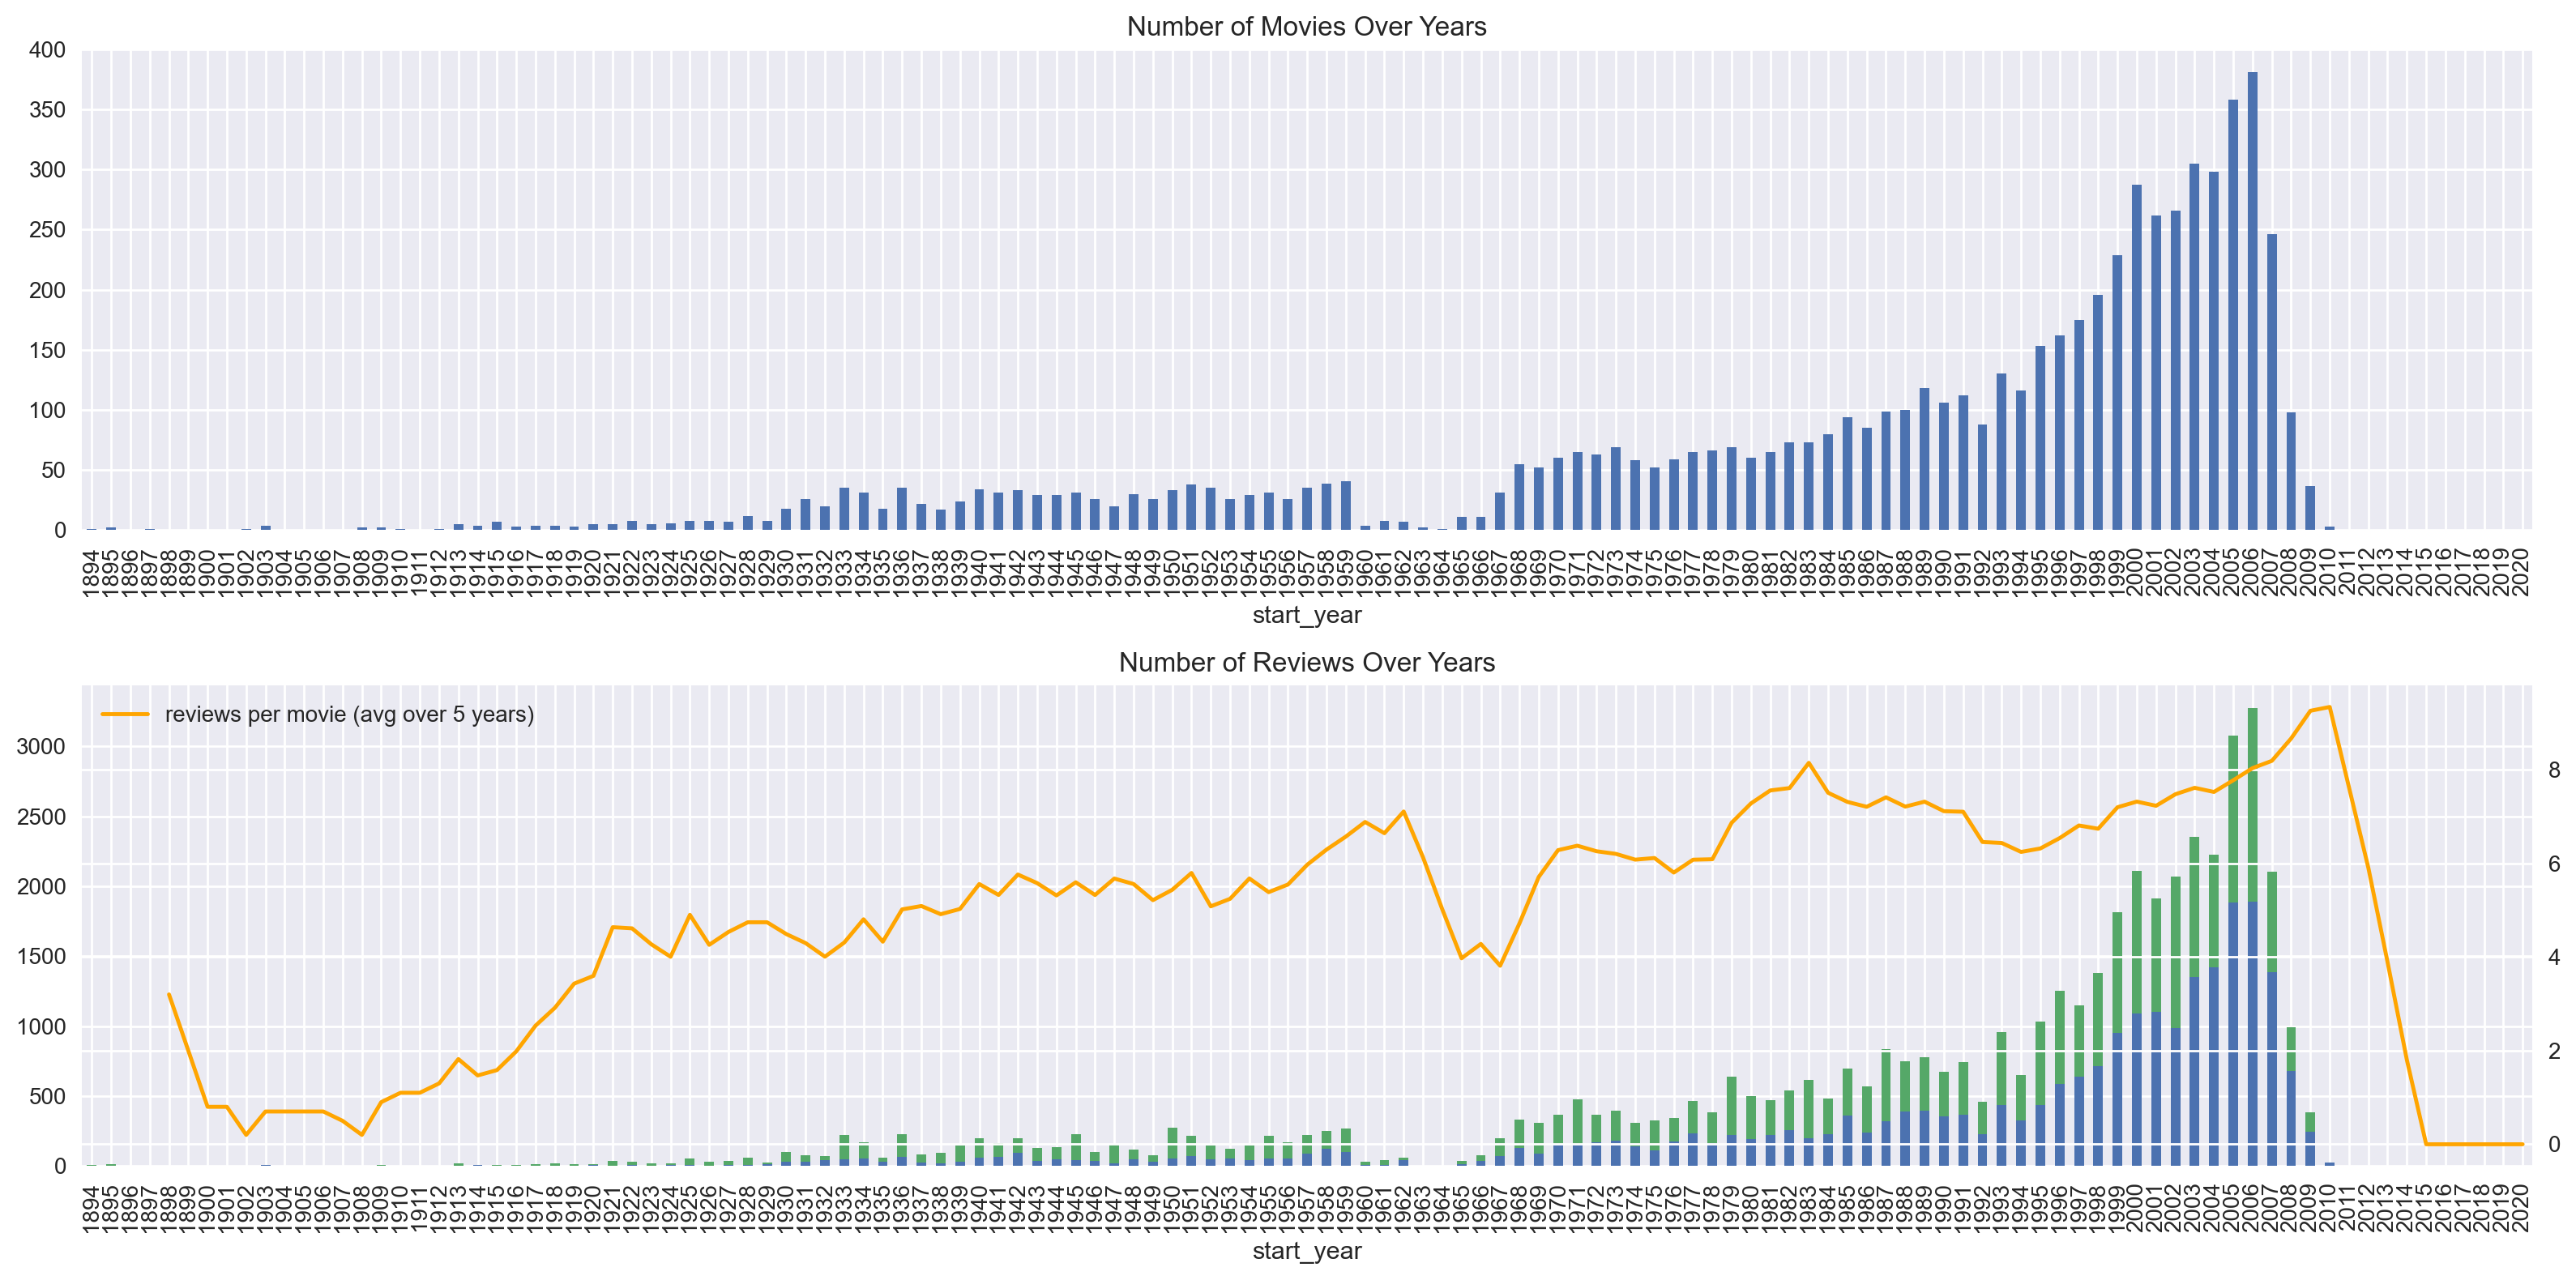

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

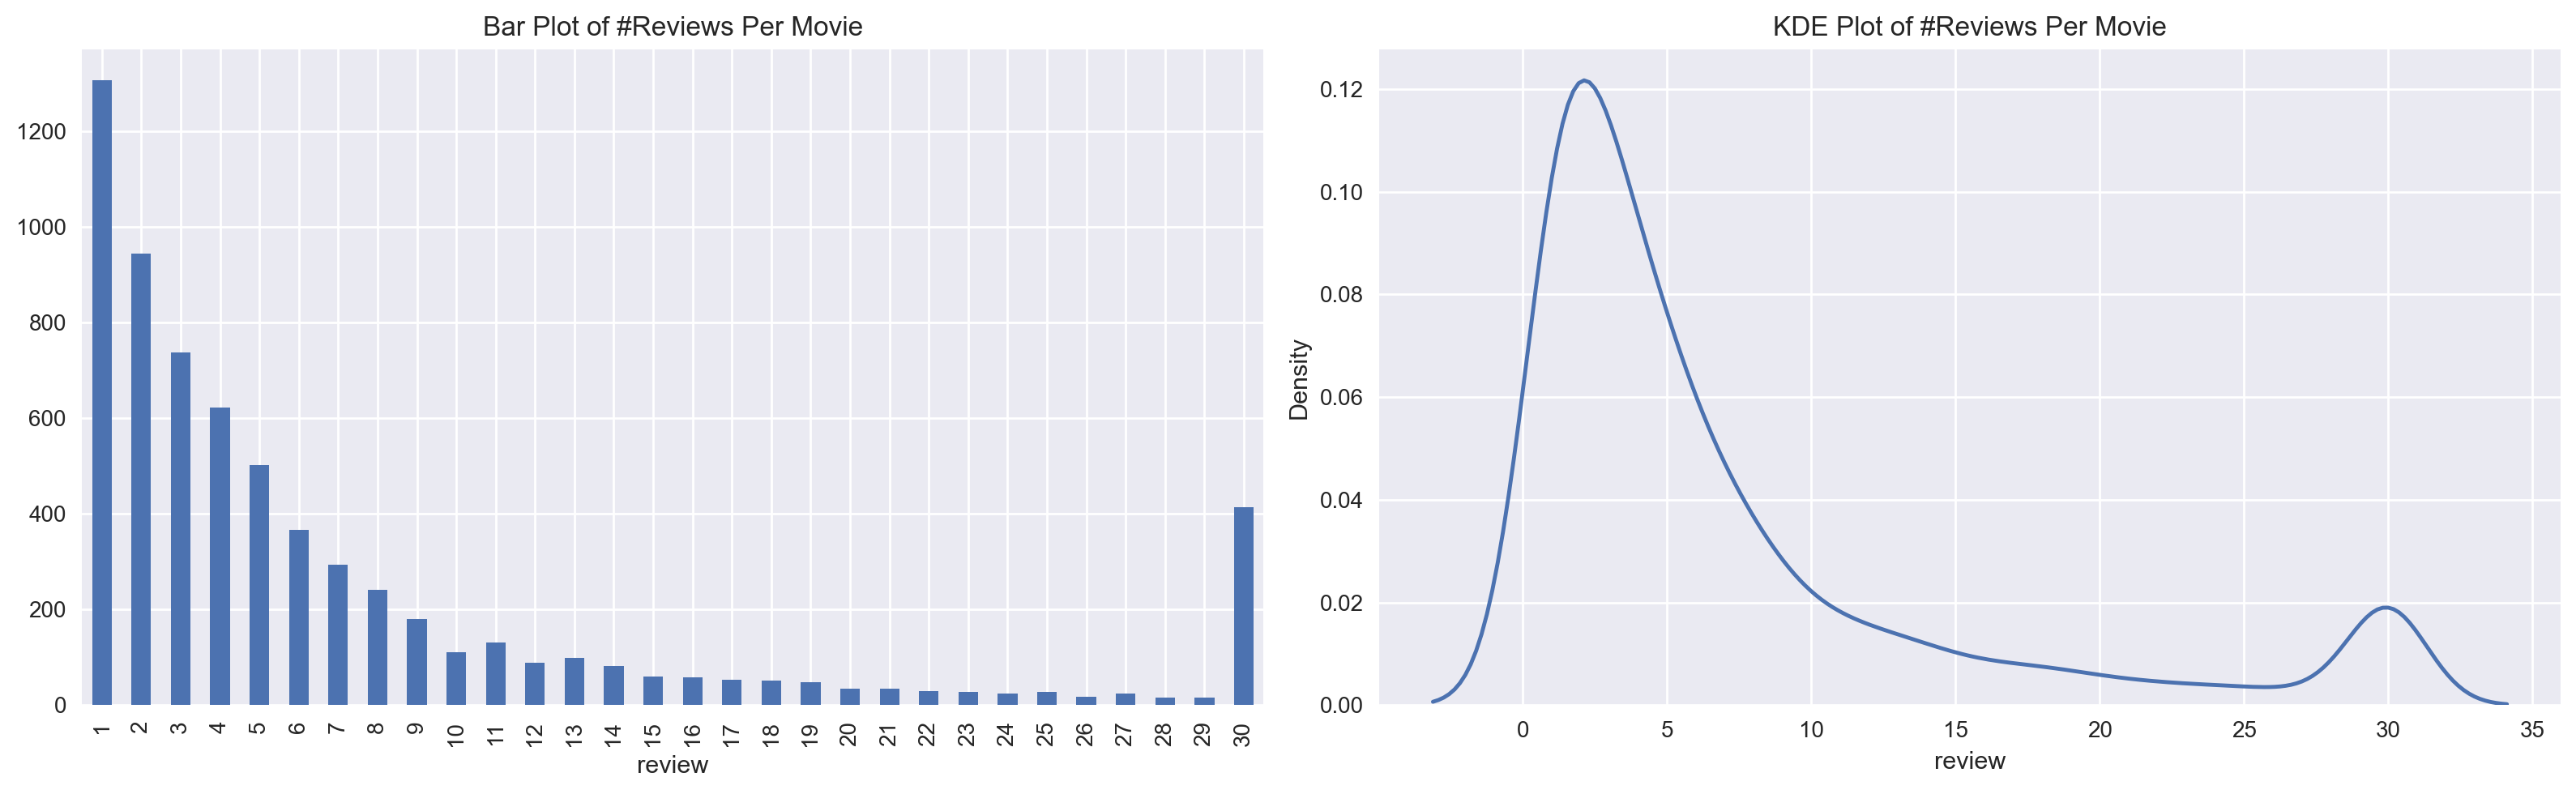

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

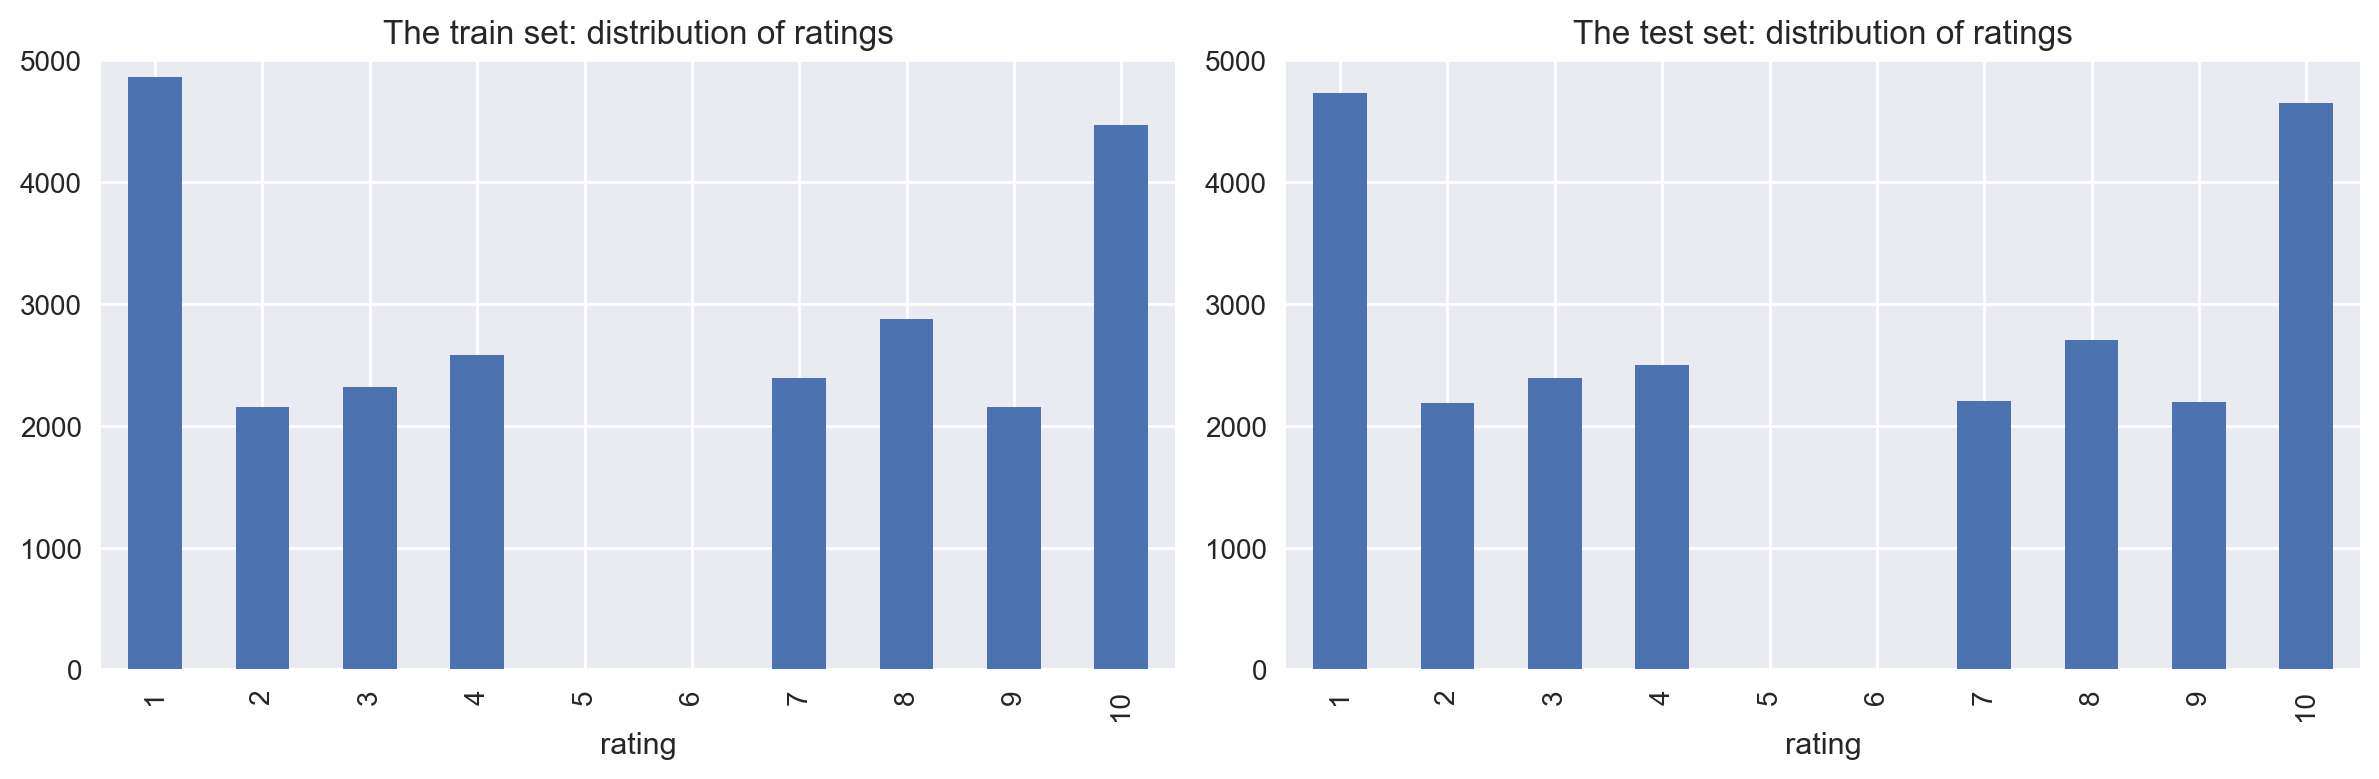

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/var/folders/t4/cv9v6mnn7svb1df20csb3s2r0000gn/T/ipykernel_9265/2564148758.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/t4/cv9v6mnn7svb1df20csb3s2r0000gn/T/ipykernel_9265/2564148758.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/var/folders/t4/cv9v6mnn7svb1df20csb3s2r0000gn/T/ipykernel_9265/2564148758.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/t4/cv9v6mnn7svb1df20csb3s2r0000gn/T/ipyke

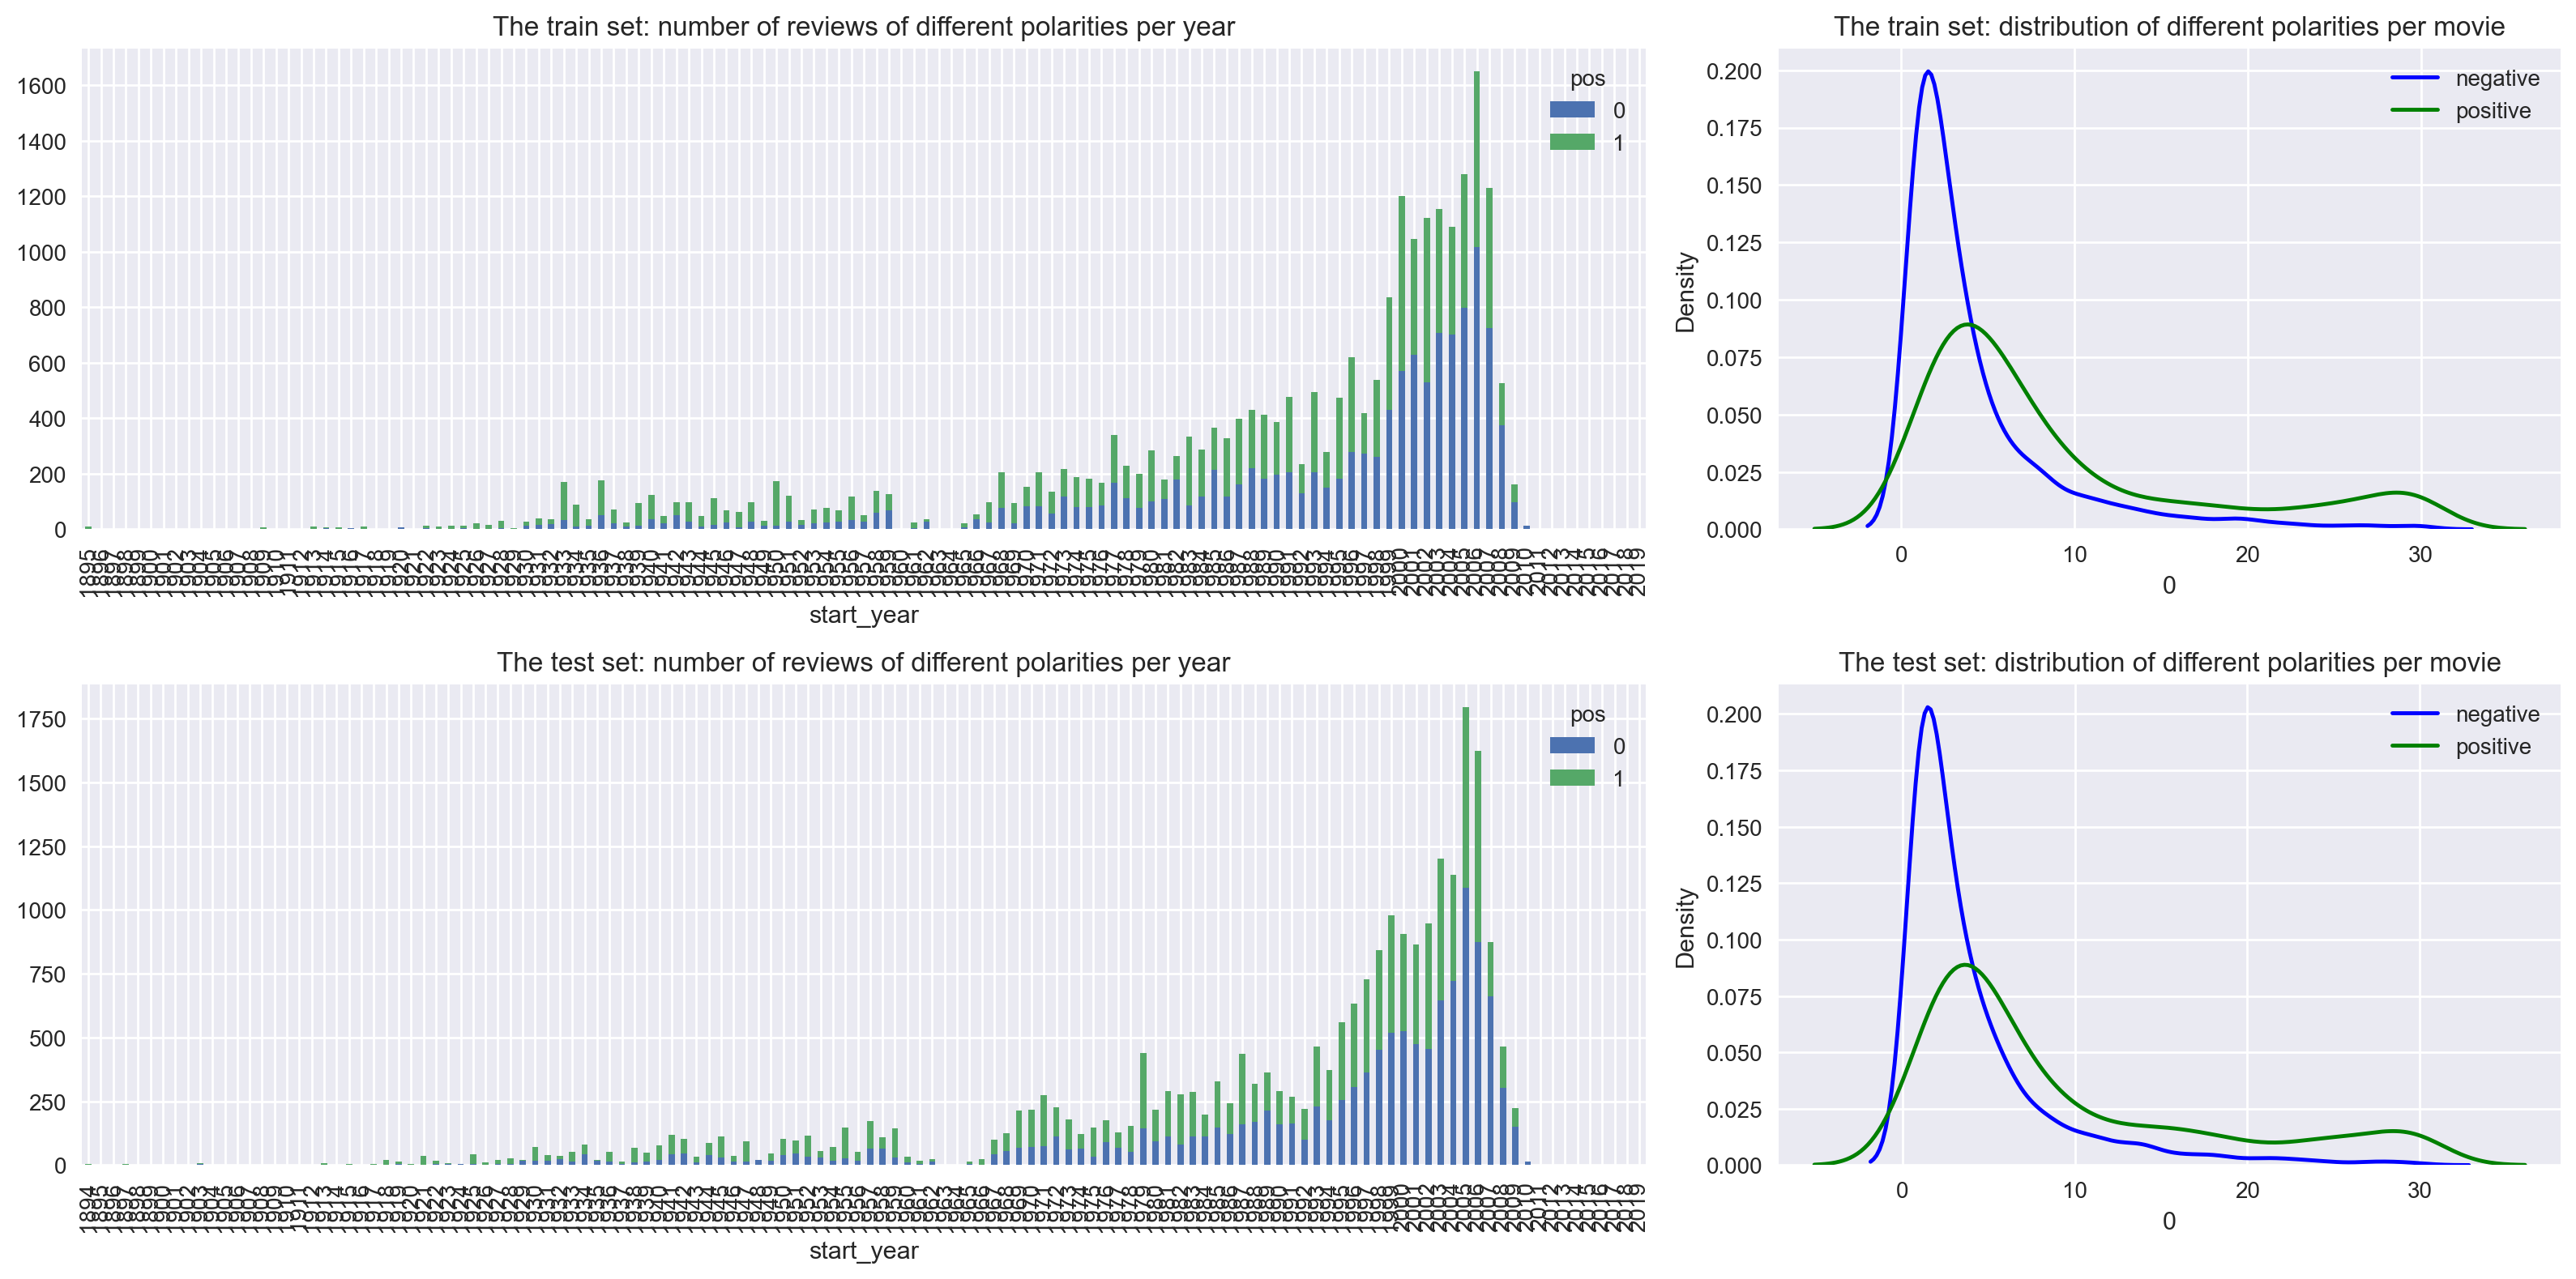

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [11]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

pattern = r'[a-zA-Z]'

def apply_pattern(row):
    return re.sub(pattern, " ", row)

new_text = df_reviews['review'].apply(apply_pattern)

def lemmatize(text):
    doc = nlp(text.lower())
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

df_reviews['review_norm'] = new_text.apply(lemmatize)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [14]:
from sklearn.dummy import DummyClassifier

def dummy(features_train, target_train, features_valid, target_valid):
    dummy_class = DummyClassifier(strategy='uniform')
    dummy_class.fit(features_train, target_train)
    predict_score = dummy_class.predict(features_valid)
    dummy_score = accuracy_score(predict_score, target_valid)
    print(predict_score)
    print(dummy_score)
    return

In [15]:
dummy(df_reviews_train, train_target, df_reviews_test, test_target)


[0 1 0 ... 1 0 1]
0.501041002761844


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
train_1_corpus = df_reviews_train['review_norm']
test_1_corpus = df_reviews_test['review_norm']

count_tf_idf = TfidfVectorizer(stop_words='english') 
train_features_1 = count_tf_idf.fit_transform(train_1_corpus)
test_features_1 = count_tf_idf.transform(test_1_corpus)

print('The train TF-IDF matrix size:', train_features_1.shape)
print('The test TF-IDF matrix size:', test_features_1.shape)




The train TF-IDF matrix size: (23796, 608)
The test TF-IDF matrix size: (23535, 608)


In [39]:
model_1 = LogisticRegression(random_state=54321, solver='liblinear')
model_1.fit(train_features_1, train_target)

LogisticRegression(random_state=54321, solver='liblinear')

          train  test
Accuracy   0.55  0.52
F1         0.40  0.35
APS        0.58  0.53
ROC AUC    0.59  0.54


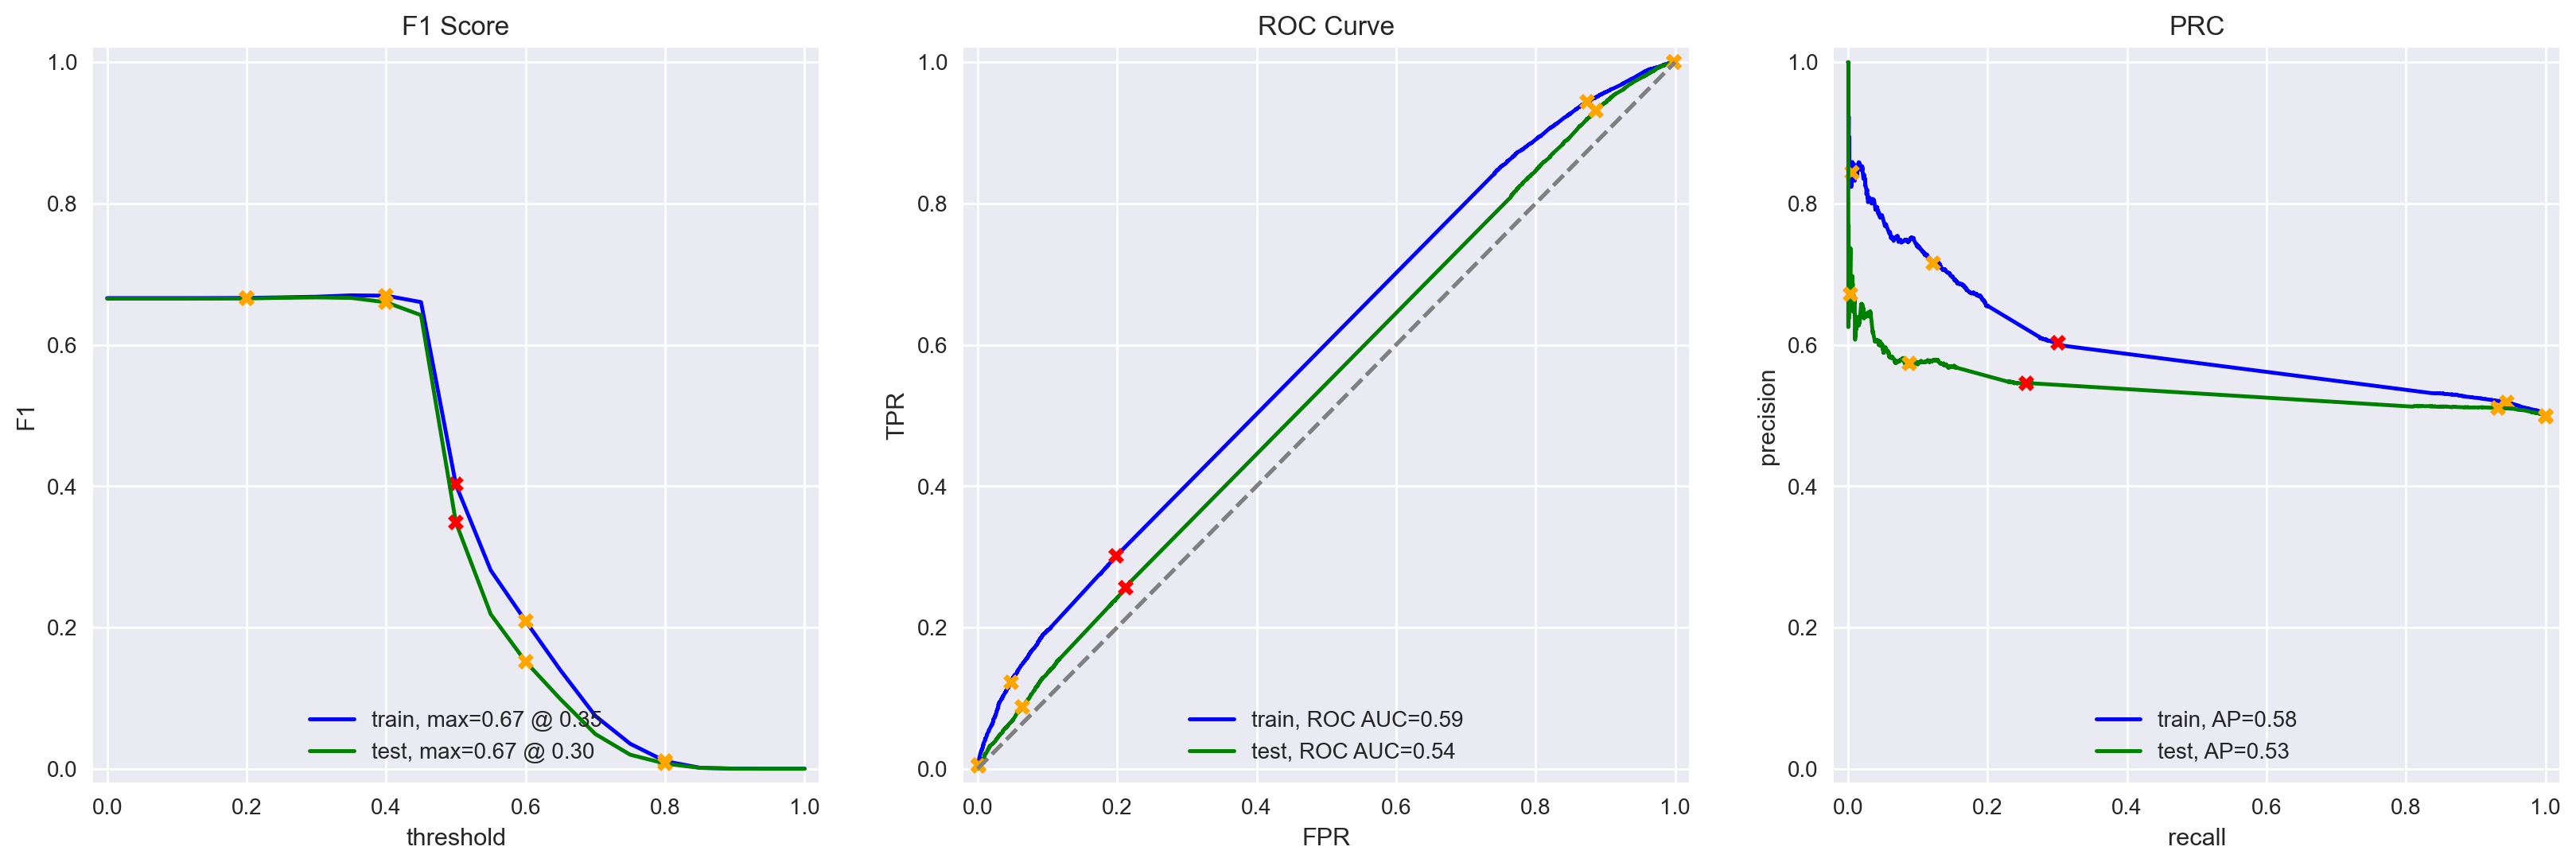

In [40]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [41]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [42]:
df_reviews_test['new_tokens'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)
df_reviews_train['new_tokens'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)


In [55]:
train_2_corpus = df_reviews_train['new_tokens']
test_2_corpus = df_reviews_test['new_tokens']

count_tf_idf_2 = TfidfVectorizer(stop_words='english') 
train_features_2 = count_tf_idf_2.fit_transform(train_2_corpus)
test_features_2 = count_tf_idf_2.transform(test_2_corpus)

print('The train TF-IDF matrix size:', train_features_2.shape)
print('The test TF-IDF matrix size:', test_features_2.shape)

The train TF-IDF matrix size: (23796, 608)
The test TF-IDF matrix size: (23535, 608)


In [56]:
model_2 = LogisticRegression(random_state=54321, solver='liblinear')
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=54321, solver='liblinear')

          train  test
Accuracy   0.55  0.52
F1         0.40  0.35
APS        0.58  0.53
ROC AUC    0.59  0.54


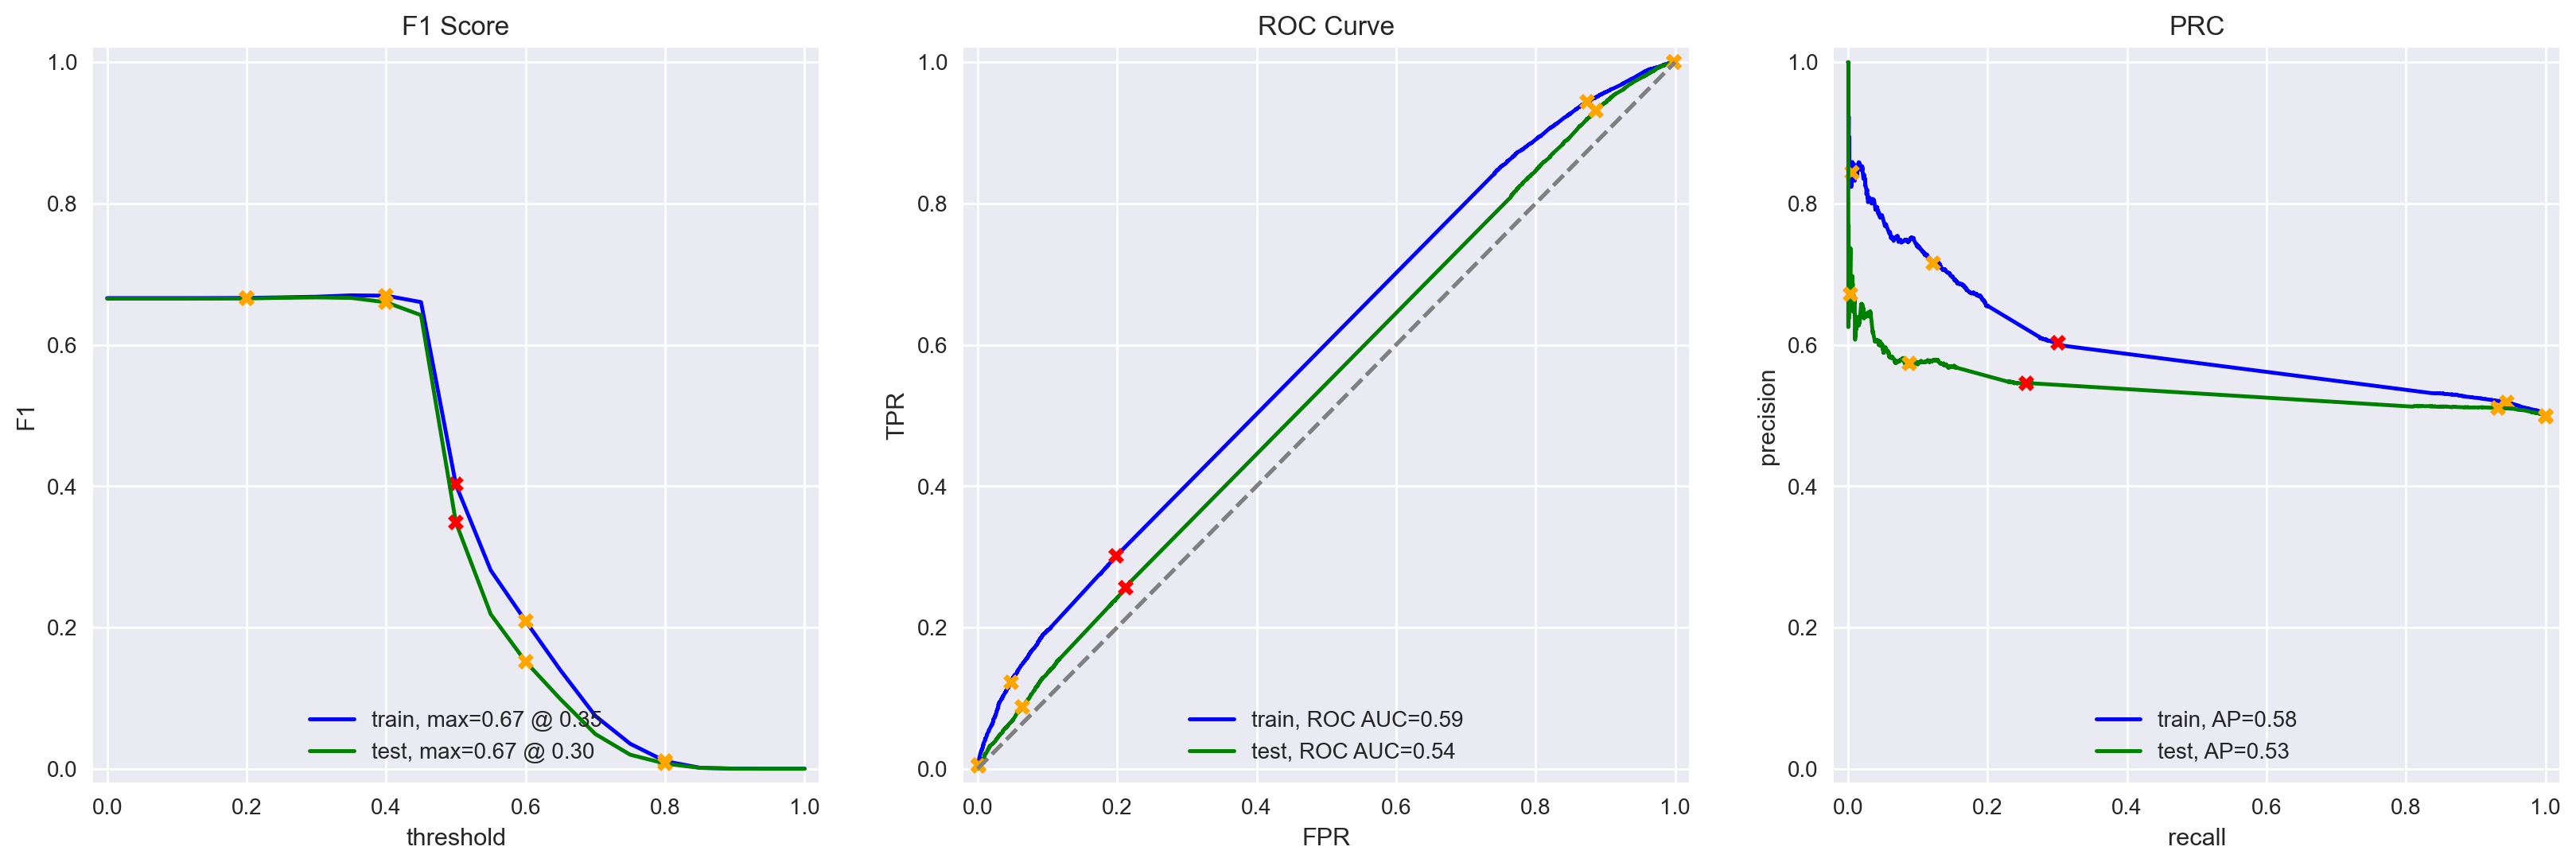

In [57]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [46]:
from lightgbm import LGBMClassifier

In [58]:
train_4_corpus = df_reviews_train['new_tokens']
test_4_corpus = df_reviews_test['new_tokens']

count_tf_idf_4 = TfidfVectorizer(stop_words='english') 
train_features_4 = count_tf_idf_4.fit_transform(train_4_corpus)
test_features_4 = count_tf_idf_4.transform(test_4_corpus)

print('The train TF-IDF matrix size:', train_features_4.shape)
print('The test TF-IDF matrix size:', test_features_4.shape)


The train TF-IDF matrix size: (23796, 608)
The test TF-IDF matrix size: (23535, 608)


In [59]:
model_4 = LGBMClassifier(num_leaves=5, max_depth=10, n_estimators=15, random_state=54321)
model_4.fit(train_features_4, train_target)

LGBMClassifier(max_depth=10, n_estimators=15, num_leaves=5, random_state=54321)

          train  test
Accuracy   0.52  0.52
F1         0.66  0.66
APS        0.53  0.51
ROC AUC    0.54  0.52


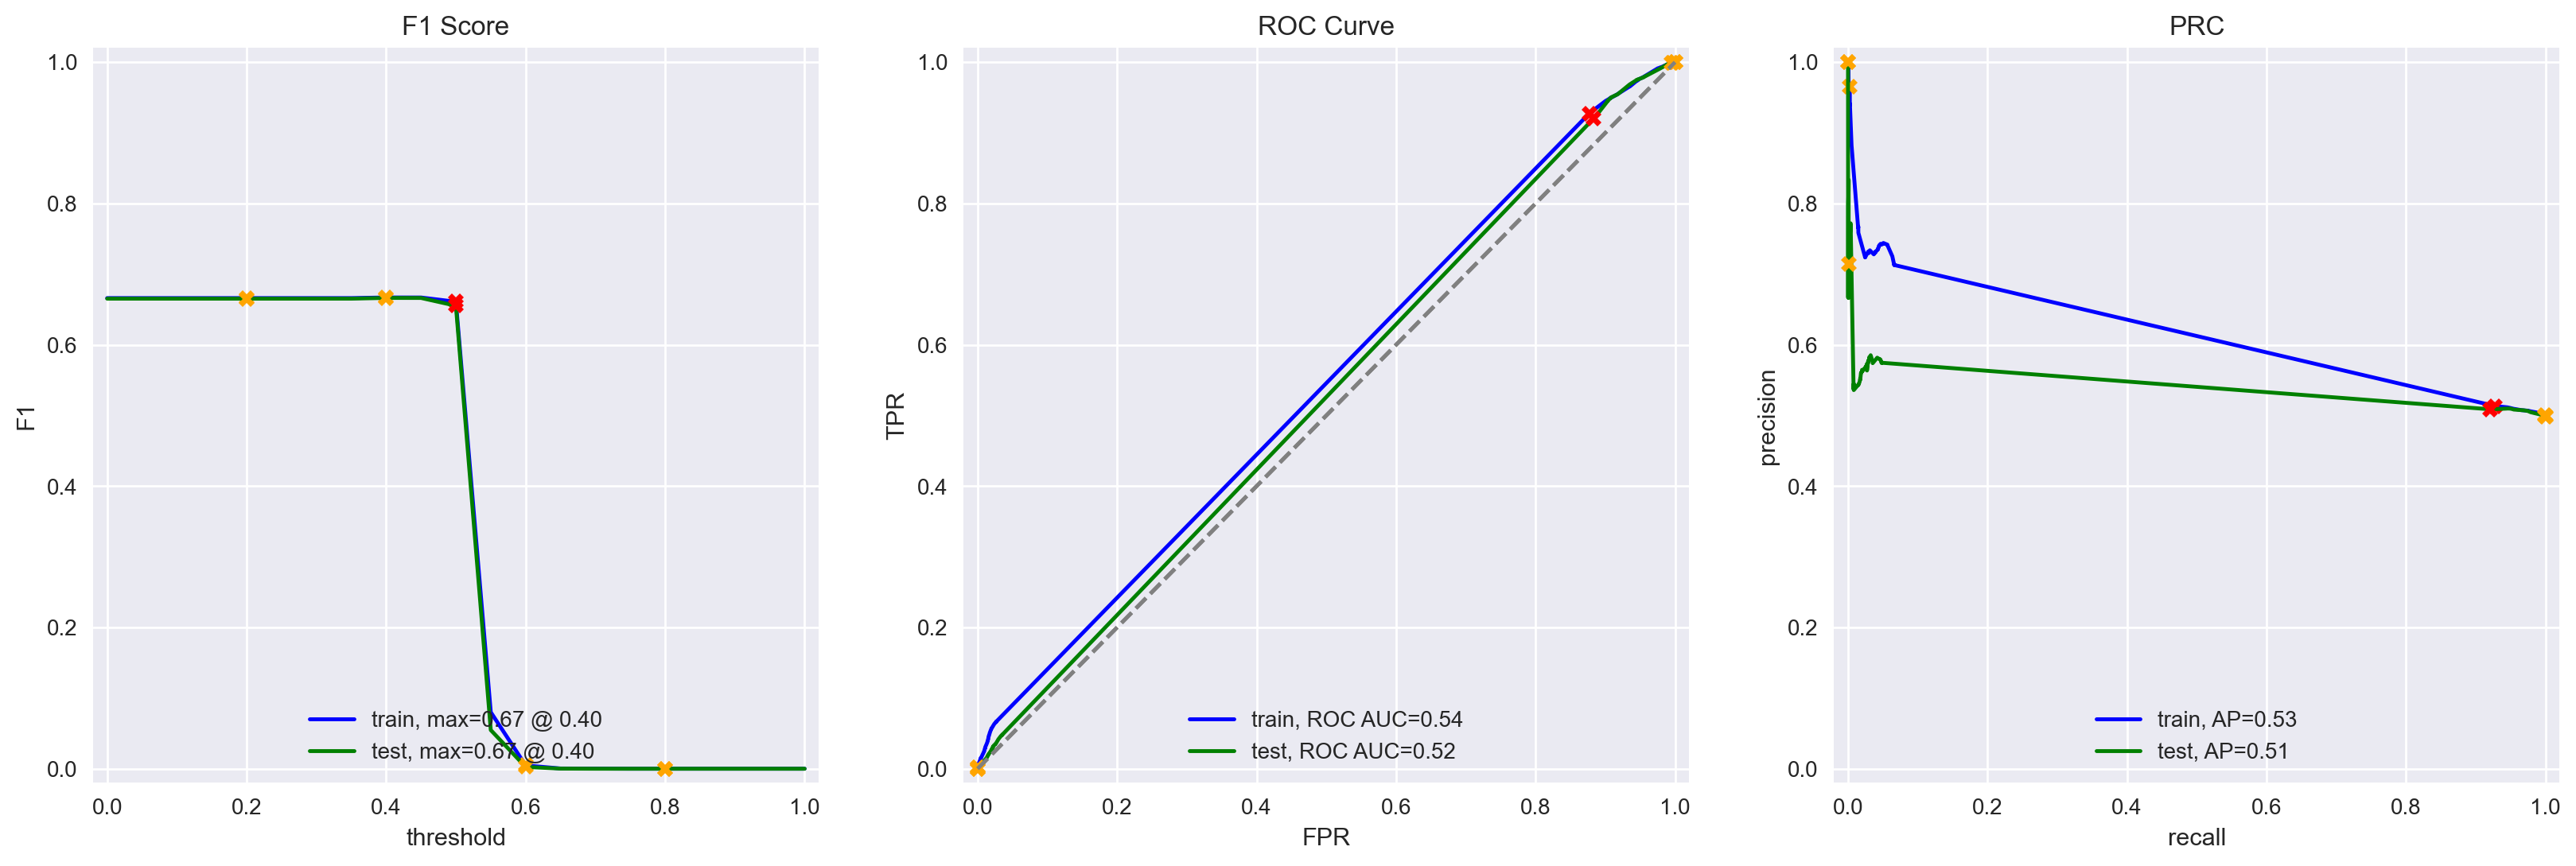

In [60]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Model 9 - BERT

In [29]:
#import torch
#import transformers
#from transformers import AlbertTokenizer, AlbertModel, AlbertConfig

In [30]:
#tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
#config = AlbertConfig.from_pretrained('albert-base-v2')
#model = AlbertModel.from_pretrained('albert-base-v2')

In [31]:
'''def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)'''

"def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):\n    \n    ids_list = []\n    attention_mask_list = []\n\n    # text to padded ids of tokens along with their attention masks\n    \n    # <put your code here to create ids_list and attention_mask_list>\n    \n    if force_device is not None:\n        device = torch.device(force_device)\n    else:\n        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n        \n    model.to(device)\n    if not disable_progress_bar:\n        print(f'Using the {device} device.')\n    \n    # gettings embeddings in batches\n\n    embeddings = []\n\n    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):\n            \n        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)\n        # <put your code here to create attention_mask_batch\n            \n        with torch.no_grad():            \n       

In [32]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [33]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [34]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [35]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

pattern = r'[a-zA-Z]'

def apply_pattern(row):
    return re.sub(pattern, " ", row)

new_text = my_reviews['review'].apply(apply_pattern)

def lemmatize(text):
    doc = nlp(text.lower())
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

my_reviews['review_norm'] = new_text.apply(lemmatize)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",", ."
1,"Well, I was bored and felt asleep in the middl...",", ..."
2,I was really fascinated with the movie,
3,Even the actors looked really old and disinter...,...
4,I didn't expect the reboot to be so good! Writ...,' ! ...
5,"The movie had its upsides and downsides, but I...",", ..."
6,What a rotten attempt at a comedy. Not a singl...,. ...
7,Launching on Netflix was a brave move & I real...,& ...


### Model 2

In [61]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:                           ,                      .
0.50:       ,                                                        .
0.50:                                        
0.50:                                                      ,                                      .        
0.50:         '                                  !                                               
0.50:                                          ,                            '                 .            
0.50:                                    .                         ,                                 ,     
0.50:                                         &                                                            


### Model 3

In [63]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:                           ,                      .
0.50:       ,                                                        .
0.50:                                        
0.50:                                                      ,                                      .        
0.50:         '                                  !                                               
0.50:                                          ,                            '                 .            
0.50:                                    .                         ,                                 ,     
0.50:                                         &                                                            


### Model 4

In [64]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = count_tf_idf
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:                           ,                      .
0.50:       ,                                                        .
0.50:                                        
0.50:                                                      ,                                      .        
0.50:         '                                  !                                               
0.50:                                          ,                            '                 .            
0.50:                                    .                         ,                                 ,     
0.50:                                         &                                                            


### Model 9

In [ ]:
'''texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')'''

## Conclusions

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions